<a href="https://colab.research.google.com/github/Juliarty/kdd-project/blob/main/Kdd_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовка данных и модели.

В качестве данных взят датасет https://www.kaggle.com/pavelbiz/eyes-rtte, который представляет собой набор изображений мужских и женских глаз. Также в данном ноутбуке используется модель, обученная с использованием кода из https://www.kaggle.com/davidbroberts/male-or-female-eyes-simple-cnn.

In [34]:
!gdown --id 1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF 

Downloading...
From: https://drive.google.com/uc?id=1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF
To: /content/eyes-rtte-train-test-split.zip
100% 43.1M/43.1M [00:00<00:00, 60.2MB/s]


In [36]:
!unzip -q -n eyes-rtte-train-test-split.zip

In [7]:
# Do imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



In [38]:
# Setup some config variables
batch_size = 50
image_size = (256,256)
base_path = './data'
test_path = base_path + '/test'
train_path = base_path + '/train'

seed = 42

In [39]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = image_size,
    batch_size = batch_size,
)

Found 1154 files belonging to 2 classes.


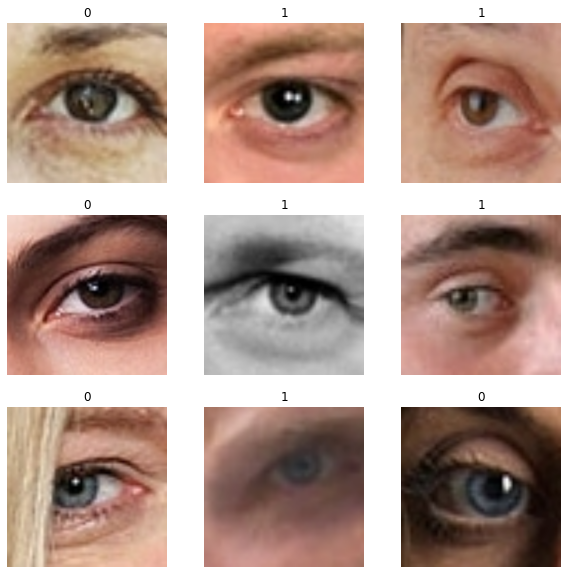

In [40]:
# Display a few images, label 0 is female, label 1 is male
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [41]:
# Setup the model. This is a stock model definition from the keras website. keras.io
#
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    x = inputs
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [42]:
# download the trained model
!mkdir model
!cd model
!gdown --id 19ZoXl-McdOlTlEbtsl65Ip8zpUo0PpC_ -O model/model_parameters.h5

mkdir: cannot create directory ‘model’: File exists
Downloading...
From: https://drive.google.com/uc?id=19ZoXl-McdOlTlEbtsl65Ip8zpUo0PpC_
To: /content/model/model_parameters.h5
100% 33.6M/33.6M [00:00<00:00, 65.3MB/s]


In [43]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights('./model/model_parameters.h5')
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


24/24 - 119s - loss: 0.1395 - accuracy: 0.9497 - 119s/epoch - 5s/step
Restored model, accuracy: 94.97%


#1. Поиск примеров.

In [44]:
# Prediction function, call with /path/to/image.jpg
# Returns the probability of being male
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    # Predict & score
    predictions = model.predict(img_array)
    return predictions[0][0]

    #print("This image is %.2f percent female and %.2f percent male." % (100 * (1 - score), 100 * score))
    #plt.imshow(img);


In [47]:
from glob import glob
female_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/femaleeyes/*')}

In [48]:
male_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/maleeyes/*')}

In [82]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

def show_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    # Predict & score
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent female and %.2f percent male." % (100 * (1 - score), 100 * score))
    plt.imshow(img);

In [111]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

import numpy as np
def get_example(img_to_prediction, closest_to, greater_than=0, less_than=1):
  for item in img_to_prediction.items():
    img = item[0]
    dist = np.abs(closest_to - item[1])

    if item[1] <= less_than and greater_than <= item[1]:
      break

  for item in img_to_prediction.items():
    if np.abs(closest_to - item[1]) < dist \
    and item[1] >= greater_than and item[1] <= less_than:
        img = item[0]
        dist = np.abs(closest_to - item[1])

  return img


This image is 1.03 percent female and 98.97 percent male.


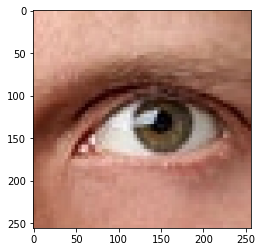

In [112]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
true_high_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.99)
show_image(true_high_male_img_path)

This image is 98.99 percent female and 1.01 percent male.


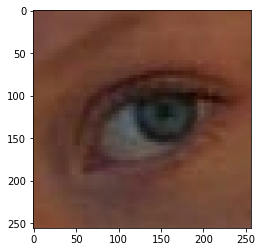

In [113]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
true_high_female_img_path = get_example(female_img_to_prediction, 0, 0.01, 0.5)
show_image(true_high_female_img_path)

This image is 42.71 percent female and 57.29 percent male.


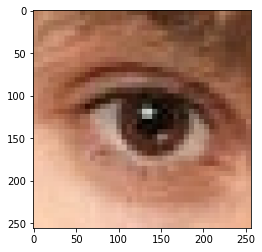

In [114]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
true_low_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.6)
show_image(true_low_male_img_path)


This image is 57.63 percent female and 42.37 percent male.


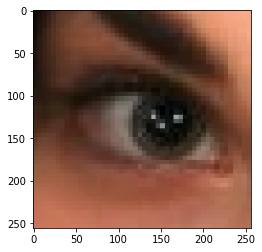

In [115]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
true_low_female_img_path = get_example(female_img_to_prediction, 0, 0.4, 0.5)
show_image(true_low_female_img_path)


This image is 96.08 percent female and 3.92 percent male.


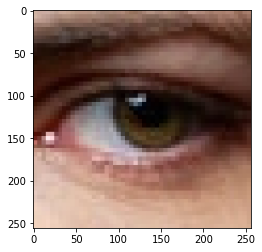

In [121]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
false_lowest_male_img_path = get_example(male_img_to_prediction, 0, 0, 0.5)
show_image(false_lowest_male_img_path)

This image is 0.69 percent female and 99.31 percent male.


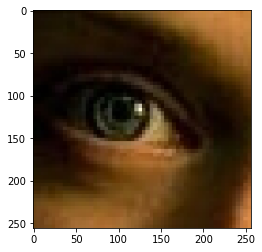

In [120]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
false_lowest_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 1)
show_image(false_lowest_female_img_path)

This image is 59.52 percent female and 40.48 percent male.


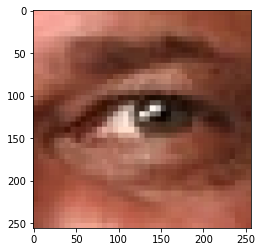

In [118]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
false_low_male_img_path = get_example(male_img_to_prediction, 0, 0.4, 0.5)
show_image(false_low_male_img_path)

This image is 41.08 percent female and 58.92 percent male.


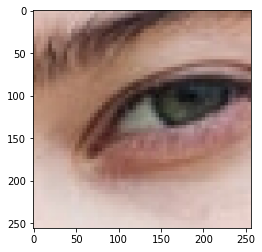

In [124]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
false_low_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 0.6)
show_image(false_low_female_img_path)